# Seattle Collisions Model Definition

This notebook cover the model definition with clustering for the maps and time series.  Ball Tree is used for the clustering and Prophet it used for the time series.  Prophet is simply awesome and a joy to work with compared to ARIMA and some of the other statsmodels.

Two goals here - first was to come up with count-based time series for collisions, second was to cluster the collisions.

In [3]:
#!conda install -c conda-forge fbprophet -y
#!pip install --upgrade plotly

In [ ]:
#!conda install -c conda-forge folium -y
#!pip install --upgrade folium

In [1]:
from fbprophet import Prophet
from fbprophet.serialize import model_to_json, model_from_json

from sklearn.neighbors import BallTree
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import json
from math import sqrt
import pandas as pd
import types
import itertools
import numpy as np
from datetime import datetime, timedelta, timezone 
import time

import os
import folium
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline

In [ ]:
df = pd.read_csv('Seattle_Collisions_Final.csv', low_memory = False, parse_dates=True, index_col=0)
print('File downloaded')
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])
df.info()

In [ ]:
df_weather = pd.read_csv('Seattle_Weather_Daily.csv', low_memory = False, parse_dates=True, index_col=0)
print('File downloaded')
df_weather.info()

In [4]:
def get_weekdays(df_source):
    return df_source[(df_source.WEEKDAY == 0)].copy(), df_source[(df_source.WEEKDAY == 1)].copy(), df_source[(df_source.WEEKDAY == 2)].copy(),\
            df_source[(df_source.WEEKDAY == 3)].copy(), df_source[(df_source.WEEKDAY == 4)].copy(), df_source[(df_source.WEEKDAY == 5)].copy(),\
                df_source[(df_source.WEEKDAY == 6)].copy()

def get_workweek_weekend(df_source):
    return df_source[(df_source.WEEKDAY.isin([0,1,2,3,4]))], df_source[(df_source.WEEKDAY.isin([5,6]))]

def get_top(df_source):
    try:
        df_source["XY"] = df_source["X"].astype(str) + "," + df_source["Y"].astype(str)
        return df_source.XY.value_counts().max().astype(int)
    except:
        return 0

def display_top(df_source, largest=5):
    df_source["XY"] = df_source["X"].astype(str) + "," + df_source["Y"].astype(str)
    print(df_source.XY.value_counts().nlargest(largest))

def map_clusters(map, df_clustered, df_orginal = None, cluster_color = 'red'):
    #map.location = [df_clustered['Y'][0], df_clustered['X'][0]]
    if isinstance(df_orginal, pd.DataFrame):
        df_orginal['XY'] = df_orginal['X'].astype(str) + "," + df_orginal['Y'].astype(str)
        df_top = df_orginal.XY.value_counts().nlargest(3)
        df_top = pd.DataFrame(list(df_top.index.str.split(','))).astype(float)
        for lat, lon in zip(df_top[1], df_top[0]):
            folium.CircleMarker(
                [lat, lon],
                radius=14,
                color=cluster_color,
                fill=True,
                fill_color='yellow',
                fill_opacity=0.5
            ).add_to(map)

    if isinstance(df_clustered, pd.DataFrame):
        for lat, lon in zip(df_clustered['Y'], df_clustered['X']):
            folium.CircleMarker(
                [lat, lon],
                radius=7,
                color=cluster_color,
                fill=True,
                fill_color='orange',
                fill_opacity=0.5
            ).add_to(map)
    else:
        print('No cluster to map: ' + cluster_color)

In [37]:
def get_day_max_temperature(dfw, target_date):
    return dfw[(dfw.DATE == target_date)]['TEMPERATURE'].max()

def get_day_min_temperature(dfw, target_date):
    return dfw[(dfw.DATE == target_date)]['TEMPERATURE'].min()

def get_day_total_precipitation(dfw, target_date):
    return dfw[(dfw.DATE == target_date)]['PRECIPITATION'].sum()

def get_day_solar_azimuth(dfw, target_date):
    return dfw[(dfw.DATE == target_date)]['SOLARAZIMUTH'].max()

# Time Series Modeling

After trying a few different models I wound up here.  Initial attempts at higher resolutions did not workout so I had to reframe the problem and run a time series across the entire dataset (all of Seattle instead of micro policing zones, check out EDA for details on that).  Based on EDA findings five years is about right but more experimenting/analysis could be done to refine that.

Modeling the collisions is an intermittent time series problem and a difficult one at that.  I tried using Zero Inflated Techniques (withheld from the notebook because it was a hackacthon) but nothing would work at the resolution I was looking for in time alotted.  Roadway safety uses Negative Bionomial Distribution which was tried as well but did not yield positive results for me.

https://cran.r-project.org/web/packages/tsintermittent/index.html - for review.  I elected to stick with 100% Python.

https://facebook.github.io/prophet/docs/quick_start.html

In [25]:
dft = df[(df.INCDTTM > '2014-12-31') & (df.INCDTTM < '2020-01-01') &\
         (df.HITPARKEDCAR == 0) & (df.PRECIPITATION >= 0) & (df.WEEKDAY.isin([0,1,2,3,4,5,6]))]
print(len(dft), len(dft)/(dft.INCDTTM.max() - dft.INCDTTM.min()).days)

47279 25.8921139101862


In [26]:
# There's more work to be done with the regressors but these were very nicely integrated with Prophet.
dft = dft.INCDTTM.value_counts().resample('D').sum().to_frame().reset_index()
dft.rename({'index':'ds', 'INCDTTM':'y'}, axis=1, inplace=True)
dft['rain'] = dft.apply(lambda x: get_day_total_precipitation(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
dft['temp'] = dft.apply(lambda x: get_day_min_temperature(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
dft['solar_azimuth'] = dft.apply(lambda x: get_day_solar_azimuth(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
#dft.y.plot(figsize=(18,3))
dft.head()

,ds,y,rain,temp,solar_azimuth
0,2014-12-31,32,0.00,32.1,353
1,2015-01-01,32,0.00,26.9,353
2,2015-01-02,20,0.03,32.1,353
3,2015-01-03,21,0.00,34.1,352
4,2015-01-04,18,0.21,41.1,352


In [ ]:
# There's plenty of tuning that can be done here but Prophet makes it very easy to get going.  CV is in the training notebook and documented in the FBP Github
m = Prophet(daily_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.5, growth='linear', seasonality_mode='multiplicative') 
m.add_regressor('rain', mode='multiplicative')
m.add_regressor('temp', mode='additive')
m.add_regressor('solar_azimuth', mode='multiplicative')
m.fit(dft)
future = m.make_future_dataframe(periods=10,freq='D',include_history=True)

In [50]:
# Future dataframe needs to be updated with all regressor data.
future['rain'] = future.apply(lambda x: get_day_total_precipitation(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
future['temp'] = future.apply(lambda x: get_day_min_temperature(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
future['solar_azimuth'] = future.apply(lambda x: get_day_solar_azimuth(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
future.head(), future.tail()

(          ds  rain  temp  solar_azimuth
 0 2014-12-31  0.00  32.1            353
 1 2015-01-01  0.00  26.9            353
 2 2015-01-02  0.03  32.1            353
 3 2015-01-03  0.00  34.1            352
 4 2015-01-04  0.21  41.1            352,
              ds  rain  temp  solar_azimuth
 1832 2020-01-06  0.03  42.0            352
 1833 2020-01-07  0.10  48.7            352
 1834 2020-01-08  0.00  34.2            351
 1835 2020-01-09  0.00  33.0            351
 1836 2020-01-10  0.15  34.9            351)

In [36]:
forecast = m.predict(future)
dft_results = dft.merge(forecast, how='outer', left_on='ds', right_on='ds')
dft_results[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'additive_terms','multiplicative_terms']].tail(20)

,ds,y,yhat,yhat_lower,yhat_upper,trend,additive_terms,multiplicative_terms
1817,2019-12-22,13.0,NaN,NaN,NaN,NaN,NaN,NaN
1818,2019-12-23,22.0,NaN,NaN,NaN,NaN,NaN,NaN
1819,2019-12-24,17.0,NaN,NaN,NaN,NaN,NaN,NaN
1820,2019-12-25,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1821,2019-12-26,18.0,NaN,NaN,NaN,NaN,NaN,NaN
1822,2019-12-27,17.0,NaN,NaN,NaN,NaN,NaN,NaN
1823,2019-12-28,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1824,2019-12-29,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1825,2019-12-30,20.0,NaN,NaN,NaN,NaN,NaN,NaN
1826,2019-12-31,21.0,NaN,NaN,NaN,NaN,NaN,NaN


Showing the best results here after many tries - mostly experimenting with Prophet.  RSME show below was good enough to move on but could have been improved and the regressors needed more analysis.

MAE: 4.762
RSME: 6.156


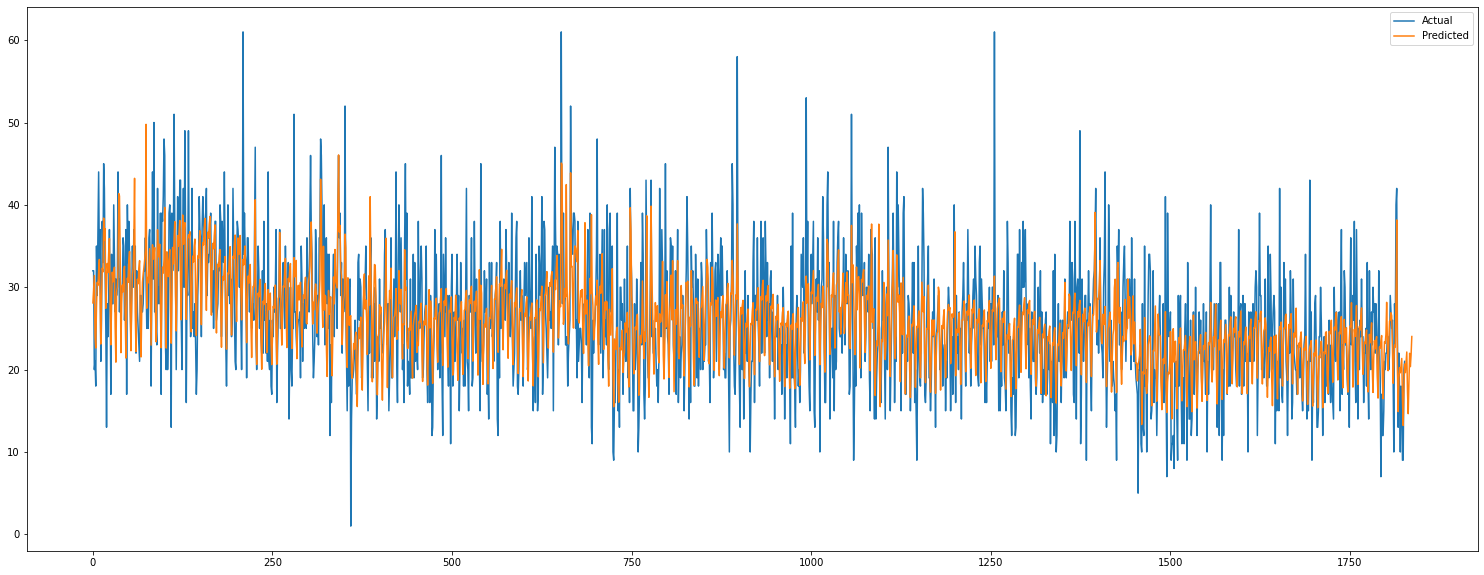

In [33]:
y_true = dft_results['y'].values
y_hat = dft_results['yhat'].values
y_hat_upper = dft_results['yhat_upper'].values
y_hat_lower = dft_results['yhat_lower'].values
mae = mean_absolute_error(y_true[:-10], y_hat[:-10])
print('MAE: %.3f' % mae)
rsme = sqrt(mean_squared_error(y_true[:-10], y_hat[:-10]))
print('RSME: %.3f' % rsme)
# plot expected vs actual
fig, ax = plt.subplots(figsize=(26,10))
plt.plot(y_true, label='Actual')
plt.plot(y_hat, label='Predicted')
#plt.plot(y_pred_upper, label='Predicted Upper')
#plt.plot(y_pred_lower, label='Predicted Lower')
plt.legend()

Prophet does not use pickling, JSON instead.

In [49]:
with open('seattle_collision_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

In [41]:
with open('seattle_collision_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

In [46]:
future = m.make_future_dataframe(periods=10,freq='D',include_history=True)
future.tail(10)

,ds
1827,2020-01-01
1828,2020-01-02
1829,2020-01-03
1830,2020-01-04
1831,2020-01-05
1832,2020-01-06
1833,2020-01-07
1834,2020-01-08
1835,2020-01-09
1836,2020-01-10


In [47]:
future['rain'] = future.apply(lambda x: get_day_total_precipitation(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
future['temp'] = future.apply(lambda x: get_day_min_temperature(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
future['solar_azimuth'] = future.apply(lambda x: get_day_solar_azimuth(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
future.head(), future.tail()

(          ds  rain  temp  solar_azimuth
 0 2014-12-31  0.00  32.1            353
 1 2015-01-01  0.00  26.9            353
 2 2015-01-02  0.03  32.1            353
 3 2015-01-03  0.00  34.1            352
 4 2015-01-04  0.21  41.1            352,
              ds  rain  temp  solar_azimuth
 1832 2020-01-06  0.03  42.0            352
 1833 2020-01-07  0.10  48.7            352
 1834 2020-01-08  0.00  34.2            351
 1835 2020-01-09  0.00  33.0            351
 1836 2020-01-10  0.15  34.9            351)

In [48]:
forecast = m.predict(future)
dft_results = dft.merge(forecast, how='outer', left_on='ds', right_on='ds')
dft_results[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'additive_terms','multiplicative_terms']].tail(20)

,ds,y,yhat,yhat_lower,yhat_upper,trend,additive_terms,multiplicative_terms
1817,2019-12-22,13.0,14.898757,7.042016,22.831433,3.829834,-0.417522,2.999202
1818,2019-12-23,22.0,19.023911,11.213976,26.873315,3.829630,-0.611284,4.127177
1819,2019-12-24,17.0,20.246301,11.959911,27.957073,3.829427,-0.775235,4.489473
1820,2019-12-25,10.0,19.607919,12.011778,27.423543,3.829223,-0.829886,4.337324
1821,2019-12-26,18.0,20.436541,11.992470,28.301792,3.829020,-1.008743,4.600724
1822,2019-12-27,17.0,21.351320,13.785394,29.151643,3.828816,-0.566569,4.724456
1823,2019-12-28,9.0,16.372230,8.852249,24.447611,3.828613,-0.377776,3.374954
1824,2019-12-29,9.0,13.215134,5.443149,21.373769,3.828409,-0.377776,2.550537
1825,2019-12-30,20.0,17.354177,9.544599,25.872812,3.828206,-0.283380,3.607265
1826,2019-12-31,21.0,20.680013,12.782707,28.262473,3.828002,-0.129365,4.436093


# Clustering

The following are the clustering routines used in the maps.  Initial efforts with DBSCAN and OPTICS were problemmatic so I revereted to Ball Tree.  BT supports haversine to provide a good distance measure and has worked ok fine.  The minimum neighors is a hack for now, needs improvement - review the evaluation/deployment notebooks for details on usage.  The first two routines are used to collect collision locations from the time series prediction.  After failing a million times at trying to figure out the best way to pick the locations and landed here - much to be improved but works ok.  The logic will grab the largest cluster, extract that based on the geohash (assigned in feature engineering notebook) from the dataframe until enough unique locations are found to satisfy forecast_size.

No doubt there's a better way...

The last function is used to as a comparison in the secondary map.  It will return the location with the most collisions based on the parameters.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html

This query will get some data to cluster, make sure that primary DF is loaded at the top of the notebook.
<br><code>
dft = df[(df.INCDTTM > '2014-12-31') & (df.INCDTTM < '2020-01-01') &\
         (df.HITPARKEDCAR == 0) & (df.PRECIPITATION >= 0) & (df.WEEKDAY.isin([0,1,2,3,4,5,6]))]
print(len(dft), len(dft)/(dft.INCDTTM.max() - dft.INCDTTM.min()).days)
    </code>

In [92]:
#nearest_neighbors_forecast(20, dft)
def nearest_neighbors_forecast(forecast_size, df_source, nearest_in_miles = 0.01, quantile = .9, minimum_neighbors = 0, verbose = False):
    try:
        columns = list('YX')
        coordinates = df_source.loc[:,columns].values
        bt = BallTree(np.radians(coordinates), metric='haversine')
        temp_df = pd.DataFrame()
        n_count = 0
        while n_count < forecast_size:
            max_index = nearest_neighbors_max_index(bt, df_source)
            temp_df = temp_df.append(df_source.iloc[max_index], ignore_index=True)
            geohash = df_source.iloc[max_index]['geohash_6']
            df_source = df_source[~(df_source.geohash_6 == geohash)]
            if verbose == True:
                print('Geohash -', geohash)
                print('Max Index -', max_index)
                print('Counter -', n_count)
                print('DF Len -', len(df_source))
            n_count += 1
        return temp_df
    except Exception as e: 
        print(e)
        return pdf.DataFrame()

In [83]:
def nearest_neighbors_max_index(bt, df_source, nearest_in_miles = 0.01, quantile = .9, minimum_neighbors = 0):
    columns = list('YX')
    coordinates = df_source.loc[:,columns].values
    radius = nearest_in_miles / 3959.87433
    neighbors = bt.query_radius(np.radians(coordinates), r=radius, count_only=True, return_distance=False)
    return np.argmax(neighbors)

In [81]:
def nearest_neighbors(df_source, nearest_in_miles = 0.01, quantile = .9, minimum_neighbors = 0):
    columns = list('YX')
    coordinates = df_source.loc[:,columns].values
    radius = nearest_in_miles / 3959.87433
    bt = BallTree(np.radians(coordinates), metric='haversine')
    neighbors = bt.query_radius(np.radians(coordinates), r=radius, count_only=True, return_distance=False)
    if np.quantile(neighbors, quantile, interpolation='nearest') > minimum_neighbors:
        return df_source.iloc[np.where(neighbors >= np.quantile(neighbors, quantile, interpolation='nearest'))[0]]
    else:
        if np.max(neighbors) > 10:
            return df_source.iloc[np.where(neighbors >= np.quantile(neighbors, quantile, interpolation='nearest'))[0]]

    return pd.DataFrame()

In [ ]:
seattle_map = folium.Map(location=[47.6062, -122.3321], zoom_start=14, control_scale=True)
map_clusters(seattle_map, nearest_neighbors(dft), 'T', cluster_color = 'red')
seattle_map